<a href="https://colab.research.google.com/github/profandersonvanin01/machine_learning/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Se fossemos passageiros no Titanic, sobreviveríamos ao desastre ❓

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, confusion_matrix, auc

In [ ]:
# Importando de um repositório no github
titanic = pd.read_csv('https://raw.githubusercontent.com/profandersonvanin01/machine_learning/main/dados_titanic/train.csv')
titanic.head()

In [ ]:
def freq(x: pd.Series, plot=False):
    contagem = x.value_counts()
    percentual = round((x.value_counts() / x.shape[0]) * 100, 3)
    res = pd.DataFrame({'values': x.unique(), 'n': contagem, 'perc': percentual})
    if plot:
        sns.countplot(x)
        plt.show()
    return res

In [ ]:
# Quantos sobreviveram e não sobreviveram
(titanic.Survived.value_counts() / titanic.shape[0]) * 100

In [ ]:
freq(titanic.Survived, plot=True)

In [ ]:
freq(titanic.Pclass, plot=True)

In [ ]:
freq(titanic.Sex, plot=True)

In [ ]:
titanic.Age.describe()

In [ ]:
sns.boxplot(x='Sex', y='Age', data=titanic)
plt.title('Distribuição de idade por sexo')
plt.show()

# **Modelagem**

Agora vamos estimar uma regressão logística para investigar as chances de sobrevivência das pessoas dados 3 preditores:


* a idade da pessoa;
* a classe em que a pessoa viajava e
* o sexo da pessoa.

O modelo terá essa configuração:

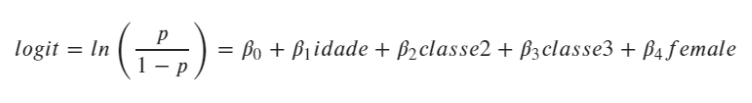

Vamos lá:

In [ ]:
# Transforma classe em categorico
titanic['Pclass'] = titanic['Pclass'].astype('category')

In [ ]:
modelo = smf.glm(formula='Survived ~ Age + Pclass + Sex', data=titanic,
                family = sm.families.Binomial()).fit()
print(modelo.summary())

Agora, vamos interpretar os resultados do modelo. Os logits estimados só podem ser interpretados em termos de aumento ou diminuição de chances de sobrevivência já que estão em escala logarítmica. Todos os coeficientes estimados foram estatisticamente significativos (p-valor abaixo de 0.05 adotando 95% de confiança).

Pessoas que viajavam na segunda classe possuem menos chances de sobrevivência do que quem viajava na primeira. Quem viajava na terceira classe possui menos chances ainda. Homens possuem menos chances de sobrevivência do que mulheres. Quanto mais velho, menores as chances de sobrevivência. Estas são as intuições gerais do modelo.

Para obtermos coeficientes mais interpretáveis, precisamos fazer uma transformação. Utilizando $e^\beta$ obtemos as chances relativas.

In [ ]:
print(np.exp(modelo.params[1:]))

Pessoas que viajavam na segunda classe tinham 0.27 das chances de sobrevivência que as pessoas da primeira classe tinham. Pessoas da terceira classe tinham 0.076 das chances que as pessoas da primeira classe tinham. Homens tinham 0.08 das chances das mulheres.

Para cada ano a mais de sobrevivência o indivíduo fica com 0.96 das chances de outro indivíduo com um ano a menos.

Podemos também gerar os mesmos dados em percentuais relativos de chances para compará-los e obter uma interpretação parecida com a interpretação da regressão linear, mas em termos de chances.

In [ ]:
(np.exp(modelo.params[1:]) - 1) * 100

Agora ficou fácil. Pessoas da segunda classe tem 73% menos chances de sobrevivência do que pessoas da primeira classe. Pessoas da terceira classe tem 92% menos chances de sobrevivência que pessoas da primeira classe. Homens tem 92% menos chances de sobrevivência do que mulheres.

Para cada ano a mais de idade, as chances diminuem 3.63%.

Agora vamos refazer o modelo utilizando scikit-learn para maior facilidade de obter as métricas de ajuste.

In [ ]:
# Agora vamos fazer com sklearn para aproveitar as métricas
model = LogisticRegression(penalty='none', solver='newton-cg')
baseline_df = titanic[['Survived', 'Pclass', 'Sex', 'Age']].dropna()
y = baseline_df.Survived
X = pd.get_dummies(baseline_df[['Pclass', 'Sex', 'Age']], drop_first=True)
print(X)

In [ ]:
model.fit(X, y)

In [ ]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(model.coef_) # Temos o mesmo modelo!

In [ ]:
# Predizendo as probabilidades
yhat = model.predict_proba(X)

In [ ]:
yhat = yhat[:, 1] # manter somente para a classe positiva

# **Métricas**

Agora vamos avaliar a qualidade do ajuste de nosso modelo. A maioria das métricas de avaliação de modelos de classificação que temos à disposição partem da matriz de confusão, uma matriz onde visualizamos os acertos e erros do modelo. Obtemos a matriz de confusão tabulando os valores observados (linhas) e os valores preditos (colunas). Ela possui, então a seguinte configuração:

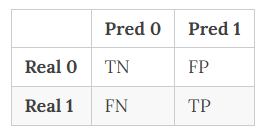

Onde TP (True Positives) são os “uns” que o modelo acertou, FN (False Negatives) são os zeros que o modelo errou (era 1 e predisse como 0 - ERRO DO TIPO 1), TN (True Negatives) são os zeros que o modelo acerto e FP (False Positives) são os “uns” que o modelo errou (era 0 e predisse como 1 - ERRO DO TIPO 2).

Vejamos a matriz de confusão do modelo que estimamos:

In [ ]:
confusion_matrix(y, model.predict(X)) # usando a função do sklearn

In [ ]:
pd.crosstab(y, model.predict(X))  # fazendo "na mão"

As métricas que vamos utilizar podem ser sintetizadas na figura abaixo:

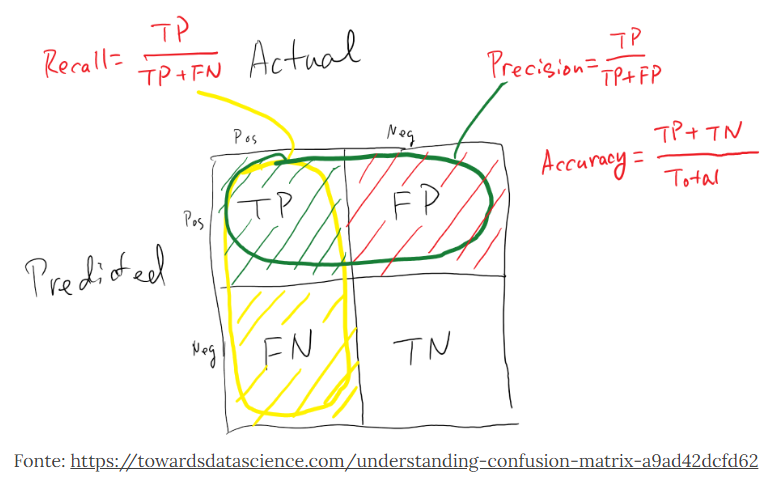

Vamos começar com a **acurácia**. Ela representa um percentual total de acertos do modelo.

In [ ]:
acuracia = accuracy_score(y, model.predict(X))
print('O modelo obteve %0.4f de acurácia.' % acuracia)

A acurácia não é uma medida muito boa para trabalhar com modelos de classificação pois ela pode nos induzir a achar que um modelo que prediz corretamente todos os zeros mas nenhum um é um modelo muito bom. Vejamos outras alternativas de métricas mais interessantes do que a acurácia.

In [ ]:
print(classification_report(y, model.predict(X)))

O classification report do SciKit-Learn nos provê as três métricas de avaliação apresentadas na figura acima.

Precision é a capacidade do modelo de não prever uma instância negativa como positiva (não cometer erro do tipo 1). Para todas as instância classificadas como positivas, qual é o percentual de acerto.

Recall é a capacidade do modelo de encontrar todas as instâncias positivas. Para todas as instâncias que são de fato positivas, qual é o percentual de acerto.

A métrica F1 conjuga as duas anteriores como uma média harmônica entre ambas. Ela deve sempre ser priorizada para comparar modelos de classificação em relação à acurácia.

Uma excelente alternativa é fazer a curva ROC e calcular o AUC (área debaixo da curva).

A curva ROC (Receiver Operating Characteristic Curve) leva em conta a TPR (True Positive Rate ou Recall ou Sensitity) e a FPR (False Positive Rate ou Specificity).

A curva ROC traça esses dois parâmetros. o AUC (Area Under the Curve) é um valor que sintetiza a informação da curva ROC. Ela varia de 0.5 a 1. Em suma, essa métrica nos diz o quanto o modelo é capaz de distinguir as duas classes. Vejamos o AUC e a curva RUC para o modelo que estimamos.

In [ ]:
print('AUC: %0.2f' % roc_auc_score(y, yhat))

In [ ]:
def plot_roc_curve(y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
plot_roc_curve(y, yhat)

Podemos considerar uma área debaixo da curva de mais de 0.7 como aceitável. Mais de 0.8 parece bom. Mais de .9 está excelente. Há também outras métricas que podemos explorar.

# **Predições**

Agora vamos fazer predições com nosso modelo? Vamos prever a nossa probabilidade de sobrevivência no Titanic e também a probabilidade de sobrevivência do coleguinha. Para fazer predições, é importante entrar os dados no modelo com o mesmo formato usado para treino.

In [ ]:
eu = pd.DataFrame({'Age':48, 'Pclass_2':1, 'Pclass_3':0, 'Sex_male':0}, index=[0])
minha_prob = model.predict_proba(eu)
print('Eu teria {}% de probabilidade de sobrevivência se estivesse no Titanic'\
      .format(round(minha_prob[:,1][0]*100, 2)))

In [ ]:
coleguinha = pd.DataFrame({'Age':32, 'Pclass_2':0, 'Pclass_3':0, 'Sex_male':1}, index=[0])
prob_do_coleguinha = model.predict_proba(coleguinha)
print('Meu coleguinha teria {}% de probabilidade de sobrevivência se estivesse no Titanic'\
      .format(round(prob_do_coleguinha[:,1][0]*100, 2)))